In [23]:
from cpymad.madx import Madx
import xtrack as xt
import numpy as np
import bpmeth
import matplotlib.pyplot as plt

### ELENA lattice from MAD-X

In [24]:
madx = Madx()

madx.call("acc-models-elena/elena.seq")
#   Apertures:
madx.call("acc-models-elena/elena.dbx")
#   Split elements to allow inserting BPMs:
madx.call("acc-models-elena/tools/splitEle_installBPM.madx")
# call strenghts for a given scenario
madx.call("acc-models-elena/scenarios/highenergy/highenergy.str")
# define beam
madx.call("acc-models-elena/scenarios/highenergy/highenergy.beam")

madx.use("elena")


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.03  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2024.04.25               +
  + Execution date: 2025.06.27 17:49:05      +
  ++++++++++++++++++++++++++++++++++++++++++++
! ELENA ring Sequence -> LNR

!

!

! Changelog:

! -  5/06/2018: started with Pavel''s optics

!   - cleaned up some commented lines and added some markers

!   - redefined randomly some names of the e-cool solenoids

!   - TODO: 

!      - cleanup useless lines. re-arrange markers "badly" used here and there.

!      - rename non-existing quad 631 and 626 !!!

! - 24/11/2020: adjusted structure to new standards. Still a lot of work to do to make it LDB compatible.

! - Sep 2021: moving toward LDB-compatible model

!

! TODO: probably need to work on arc lenght for dipoles to match GEODE/drawings/LDB.





/************************************************************************************/

/*            

In [25]:
line = xt.Line.from_madx_sequence(madx.sequence.elena)
line.particle_ref = xt.Particles(p0c=0.1, mass0=0.938272, q0=1)

bend_fint = line["lnr.mbhek.0640.h2"].edge_exit_fint
print(f"Fringe field integral in lattice: {bend_fint}")

tw = line.twiss4d()

Converting sequence "elena":   0%|          | 0/191 [00:00<?, ?it/s]

Fringe field integral in lattice: 0.424


In [26]:
line["lnr.mbhek.0640.h2"].edge_exit_fint

np.float64(0.424)

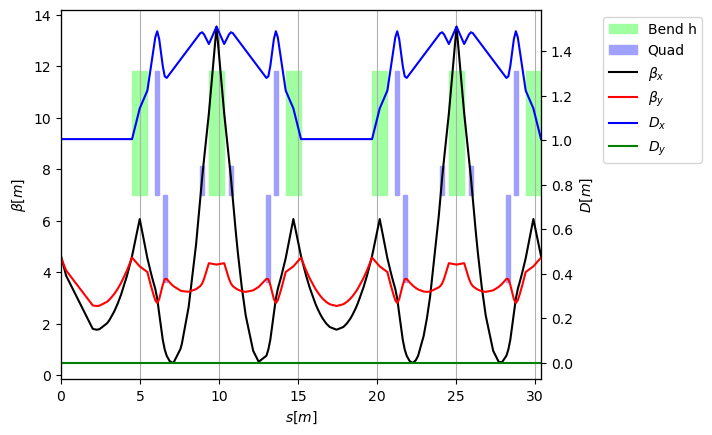

In [27]:
tw.plot()

### Numerical ELENA dipole

In [28]:
rho = 0.927
phi = 60/180*np.pi
l_magn = rho*phi
apt = 0.076
hgap = apt/2
theta_E = 17/180*np.pi
B = 5.3810e-07
Brho = B*rho
design_field=1/rho*1.001803

In [29]:
data = np.loadtxt("../dipole/ELENA_fieldmap.csv", skiprows=1, delimiter=",")[:, [0,1,2,7,8,9]]

Fitting multipoles
fitting b1...
0
fitting b2...
1
Central field in the magnet:  5.374216206768329e-07
Average field in the magnet:  5.35030667938287e-07
Rescaling field to match integrated field with design field
Central field in the magnet:  1.0855230546328931
Average field in the magnet:  1.080693635382956
Creating field expansion...
Creating Hamiltonian...


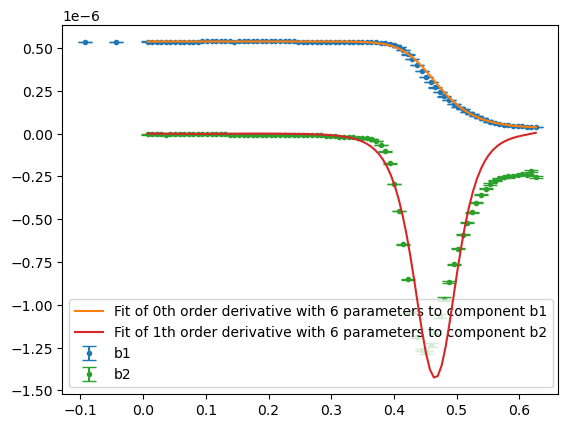

In [30]:
dipole = bpmeth.DipoleFromFieldmap(data, 1/rho, l_magn, design_field=design_field, shape="enge", hgap=apt/2, apt=apt, radius=0.05, order=2, plot=True, nphi=2)

-0.262636519872941


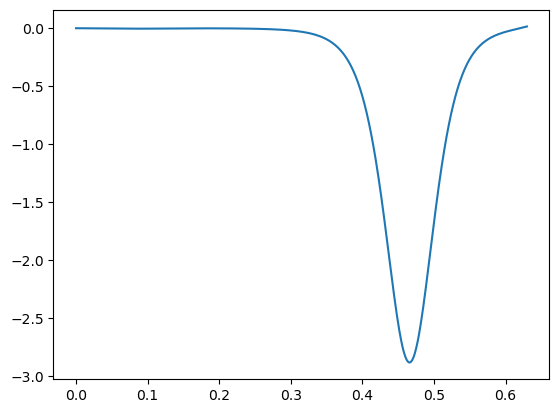

In [31]:
ss = np.linspace(0, dipole.smax, 1000)
plt.plot(ss, [dipole.b_out[1].subs({dipole.s:sss}) for sss in ss])
print(np.trapezoid([dipole.b_out[1].subs({dipole.s:sss}) for sss in ss], ss))


### Lattice without edge angles in first magnet

In [32]:
line2 = xt.Line.from_madx_sequence(madx.sequence.elena,deferred_expressions=True)
line2.particle_ref = xt.Particles(p0c=0.1, mass0=0.938272, q0=1)
line2.configure_bend_model(core='adaptive', edge='full')
tw = line2.twiss4d()
print(f"{tw.qx}")
print(f"{tw.qy}")

res = {'lnr_kq1': 2.813705672068076, 'lnr_kq2': -2.0918538880765594, 'lnr_kq3': 0.38836923739266527}
for k,v in res.items():
    line2.vars[k]=v

line2['lnr.mbhek.0135.h1'].edge_entry_fint=0.0
line2['lnr.mbhek.0135.h2'].edge_exit_fint=0.0
line2['lnr.mbhek.0135.h1'].edge_entry_angle=0.0
line2['lnr.mbhek.0135.h2'].edge_exit_angle=0.0

Converting sequence "elena":   0%|          | 0/191 [00:00<?, ?it/s]

2.3616898448610883
1.3899257304100336


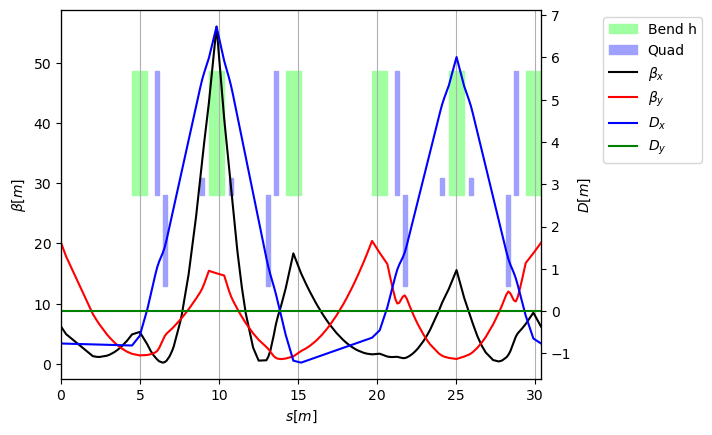

In [33]:
line2.twiss4d().plot()

### Replace a dipole

In [34]:
tab = line.get_table()
tab.show(cols=['s_start', 's_center', 's_end'])

name                          s_start      s_center         s_end
elena$start                         0             0             0
lnr.startsurvey                     0             0             0
lnr.begin                           0             0             0
section1$start                      0             0             0
drift_0                             0        0.1603        0.3206
lnr.mccay.0105                 0.3206        0.3206        0.3206
lnr.bpmeb.0110                 0.3206        0.3206        0.3206
drift_1                        0.3206       1.16575        2.0109
lnr.vvgbf.0114                 2.0109        2.0109        2.0109
drift_2                        2.0109       2.13025        2.2496
lnr.mmidinj                    2.2496        2.2496        2.2496
drift_3                        2.2496        2.3396        2.4296
lnr.mbmie.0115                 2.4296        2.4296        2.4296
drift_4                        2.4296       2.66905        2.9085
lnr.btvpa.

In [35]:
k1_edge = -line["lnr.mbhek.0135.h1"].k0*np.tan(line["lnr.mbhek.0135.h1"].edge_entry_angle)
dipole_s = line.get_s_position(at_elements="lnr.mbhek.0135.m")
dipole_len = line["lnr.mbhek.0135.h1"].length+line["lnr.mbhek.0135.h2"].length
dipole_k0 = line["lnr.mbhek.0135.h1"].k0
dipole_h = line["lnr.mbhek.0135.h1"].h

In [36]:
line["lnr.mbhek.0135.h1"].edge_entry_angle*180/np.pi

np.float64(16.45)

In [37]:
# Run this if you want to have an approximate tanh model (not even fitted)
# extent=0.2
# slope = 0.05

# dipole_A_in_str = bpmeth.DipoleVectorPotential(b1=f"{dipole_k0} * (tanh((s+{dipole_len/2})/{slope})+1)/2", curv=0)
# dipole_A_in_curv = bpmeth.DipoleVectorPotential(b1=f"{dipole_k0} * (tanh((s+{dipole_len/2})/{slope})+1)/2", curv=dipole_h)
# dipole_A_out_str = bpmeth.DipoleVectorPotential(b1=f"{dipole_k0} * (tanh(-(s-{dipole_len/2})/{slope})+1)/2", curv=0)
# dipole_A_out_curv = bpmeth.DipoleVectorPotential(b1=f"{dipole_k0} * (tanh(-(s-{dipole_len/2})/{slope})+1)/2", curv=dipole_h)

# dipole_H_in_str = bpmeth.Hamiltonian(extent, 0, dipole_A_in_str, s_start=-extent-dipole_len/2)
# dipole_H_in_curv = bpmeth.Hamiltonian(dipole_len/2, dipole_h, dipole_A_in_curv, s_start=-dipole_len/2)
# dipole_H_out_curv = bpmeth.Hamiltonian(dipole_len/2, dipole_h, dipole_A_out_curv, s_start=0)
# dipole_H_out_str = bpmeth.Hamiltonian(extent, 0, dipole_A_out_str, s_start=dipole_len/2)


In [38]:
# Run this for the dipole from ELENA
extent = (dipole.smax - dipole.smin - dipole_len)/2

dipole_A_in_str = bpmeth.GeneralVectorPotential(b=(dipole.b_in[0],), hs="0", nphi=4)
dipole_A_in_curv = bpmeth.GeneralVectorPotential(b=(dipole.b_in[0],), hs=f"{dipole_h}", nphi=4)
dipole_A_out_str = bpmeth.GeneralVectorPotential(b=(dipole.b_out[0],), hs="0", nphi=4)
dipole_A_out_curv = bpmeth.GeneralVectorPotential(b=(dipole.b_out[0],), hs=f"{dipole_h}", nphi=4)

dipole_H_in_str = bpmeth.Hamiltonian(extent, 0, dipole_A_in_str, s_start=-extent-dipole_len/2)
dipole_H_in_curv = bpmeth.Hamiltonian(dipole_len/2, dipole_h, dipole_A_in_curv, s_start=-dipole_len/2)
dipole_H_out_curv = bpmeth.Hamiltonian(dipole_len/2, dipole_h, dipole_A_out_curv, s_start=0)
dipole_H_out_str = bpmeth.Hamiltonian(extent, 0, dipole_A_out_str, s_start=dipole_len/2)

In [39]:
only_dipole_A_in_str = bpmeth.DipoleVectorPotential(b1=dipole.b_in[0], curv=0)
only_dipole_A_in_curv = bpmeth.DipoleVectorPotential(b1=dipole.b_in[0], curv=dipole_h)
only_dipole_A_out_str = bpmeth.DipoleVectorPotential(b1=dipole.b_out[0], curv=0)
only_dipole_A_out_curv = bpmeth.DipoleVectorPotential(b1=dipole.b_out[0], curv=dipole_h)

only_dipole_H_in_str = bpmeth.Hamiltonian(extent, 0, only_dipole_A_in_str, s_start=-extent-dipole_len/2)
only_dipole_H_in_curv = bpmeth.Hamiltonian(dipole_len/2, dipole_h, only_dipole_A_in_curv, s_start=-dipole_len/2)
only_dipole_H_out_curv = bpmeth.Hamiltonian(dipole_len/2, dipole_h, only_dipole_A_out_curv, s_start=0)
only_dipole_H_out_str = bpmeth.Hamiltonian(extent, 0, only_dipole_A_out_str, s_start=dipole_len/2)

1.08552305463289/(9.5963231487245e-7*exp(-29.2975762396641*s + 301.365628976563*(-s - 0.485376064979623)**4 - 19.6463646654605*(-s - 0.485376064979623)**3 - 97.997942274806*(-s - 0.485376064979623)**2) + 1)
-1.08552305463289*x/(9.5963231487245e-7*exp(-29.2975762396641*s + 301.365628976563*(-s - 0.485376064979623)**4 - 19.6463646654605*(-s - 0.485376064979623)**3 - 97.997942274806*(-s - 0.485376064979623)**2) + 1)
1.08552305463289/(9.5963231487245e-7*exp(-29.2975762396641*s + 301.365628976563*(-s - 0.485376064979623)**4 - 19.6463646654605*(-s - 0.485376064979623)**3 - 97.997942274806*(-s - 0.485376064979623)**2) + 1)
1.08552305463289*(-0.539374325782093*x**2 - x)/((1.07874865156419*x + 1)*(9.5963231487245e-7*exp(-29.2975762396641*s + 301.365628976563*(-s - 0.485376064979623)**4 - 19.6463646654605*(-s - 0.485376064979623)**3 - 97.997942274806*(-s - 0.485376064979623)**2) + 1))
1.08552305463289/(9.5963231487245e-7*exp(29.2975762396641*s + 301.365628976563*(s - 0.485376064979623)**4 - 19.6

In [40]:
dipole_A_full = bpmeth.DipoleVectorPotential(b1=f"{dipole_k0}", curv=dipole_h)
dipole_H_full = bpmeth.Hamiltonian(dipole_len, dipole_h, dipole_A_full)

1.0787486515641855
1.07874865156419*(-0.539374325782093*x**2 - x)/(1.07874865156419*x + 1)


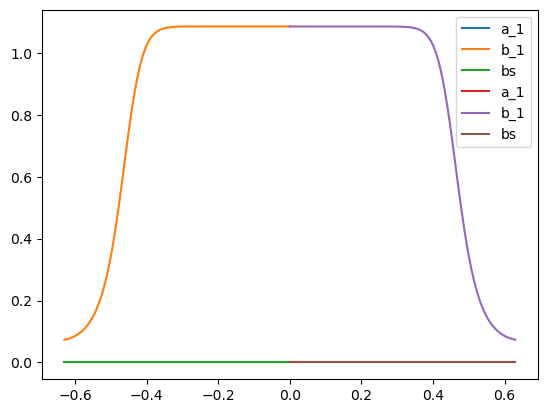

In [41]:
fig, ax = plt.subplots()
dipole_A_in_str.plot_components(ax=ax, smin=dipole.smin, smax=0)
dipole_A_out_str.plot_components(ax=ax, smin=0, smax=dipole.smax)


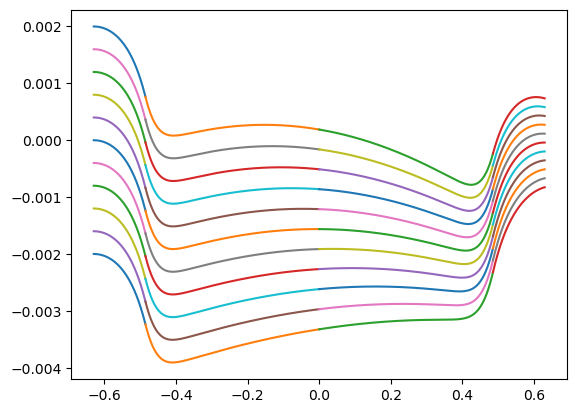

In [42]:
import xtrack as xt
p = xt.Particles(x=np.linspace(-2e-3, 2e-3, 11), y=np.linspace(-2e-3, 2e-3, 11), p0c=0.1, mass0=0.938272, q0=1)

sol_1 = dipole_H_in_str.track(p, return_sol=True)
sol_2 = dipole_H_in_curv.track(p, return_sol=True)
sol_3 = dipole_H_out_curv.track(p, return_sol=True)
sol_4 = dipole_H_out_str.track(p, return_sol=True)

fig, ax = plt.subplots()
for i, _ in enumerate(p.x):
    ax.plot(sol_1[i].t, sol_1[i].y[0])
    ax.plot(sol_2[i].t, sol_2[i].y[0])
    ax.plot(sol_3[i].t, sol_3[i].y[0])
    ax.plot(sol_4[i].t, sol_4[i].y[0])

In [43]:
line3 = line2.copy()

line3.remove("lnr.mbhek.0135.h1")
line3.remove("lnr.mbhek.0135.m")
line3.remove("lnr.mbhek.0135.h2")

line3.insert("mydipole1", dipole_H_in_str, at=dipole_s - dipole_len/2 - extent/2)
line3.insert("mydipole2", dipole_H_in_curv, at=dipole_s - dipole_len/4)
line3.insert("mydipole3", dipole_H_out_curv, at=dipole_s + dipole_len/4)
line3.insert("mydipole4", dipole_H_out_str, at=dipole_s + dipole_len/2 + extent/2)

# line3.insert("mydipole", dipole_H_full, at=dipole_s)


Slicing line:   0%|          | 0/198 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/199 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/199 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/199 [00:00<?, ?it/s]

In [44]:
line7 = line2.copy()

line7.remove("lnr.mbhek.0135.h1")
line7.remove("lnr.mbhek.0135.m")
line7.remove("lnr.mbhek.0135.h2")

line7.insert("mydipole1", only_dipole_H_in_str, at=dipole_s - dipole_len/2 - extent/2)
line7.insert("mydipole2", only_dipole_H_in_curv, at=dipole_s - dipole_len/4)
line7.insert("mydipole3", only_dipole_H_out_curv, at=dipole_s + dipole_len/4)
line7.insert("mydipole4", only_dipole_H_out_str, at=dipole_s + dipole_len/2 + extent/2)


Slicing line:   0%|          | 0/198 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/199 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/199 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/199 [00:00<?, ?it/s]

In [45]:
line["lnr.mbhek.0135.h1"].edge_entry_fint

np.float64(0.424)

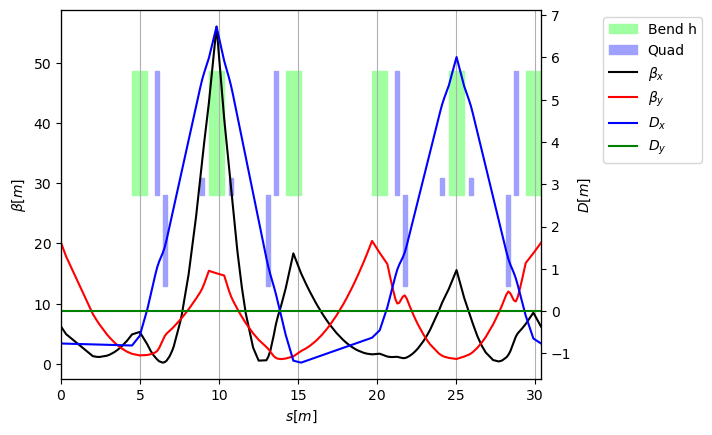

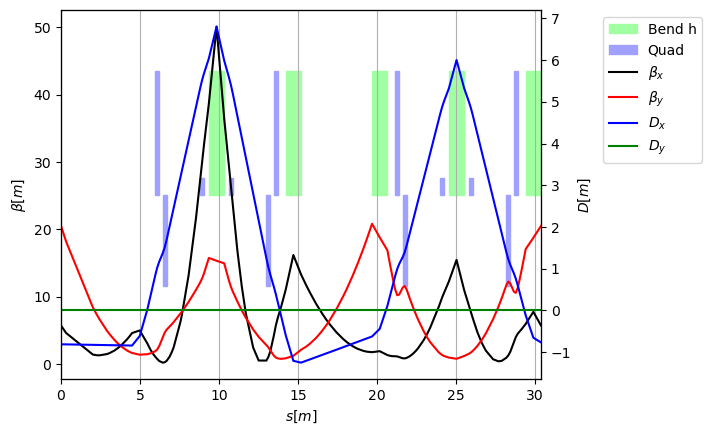

In [46]:
tw2 = line2.twiss4d()
tw3 = line3.twiss4d(include_collective=True)
# tw3 = line3.twiss4d(betx=tw2.betx[0], bety=tw2.bety[0], alfx=tw2.alfx[0], alfy=tw2.alfy[0], dx=tw2.dx[0], dpx=tw2.dpx[0], include_collective=True)
tw2.plot()
tw3.plot()

In [47]:
line6 = line2.copy()
line6["lnr.mbhek.0135.h1"].edge_entry_fint = line["lnr.mbhek.0135.h1"].edge_entry_fint
line6["lnr.mbhek.0135.h2"].edge_exit_fint = line["lnr.mbhek.0135.h2"].edge_exit_fint

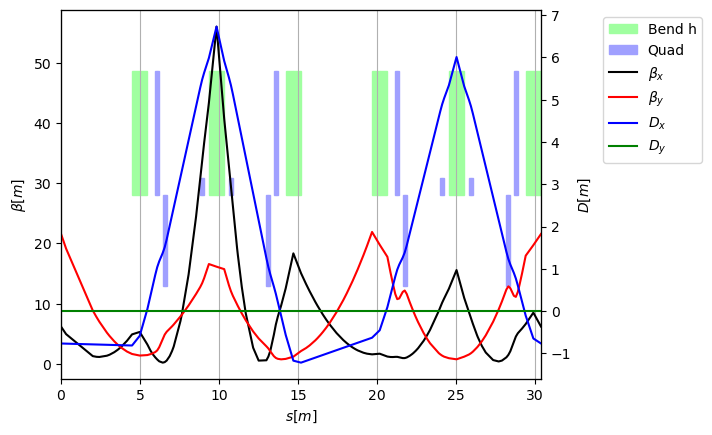

In [48]:
tw6 = line6.twiss4d()
tw6.plot()

In [49]:
tw7 = line7.twiss4d(include_collective=True)

1.08552305463289/(9.5963231487245e-7*exp(-29.2975762396641*s + 301.365628976563*(-s - 0.485376064979623)**4 - 19.6463646654605*(-s - 0.485376064979623)**3 - 97.997942274806*(-s - 0.485376064979623)**2) + 1)
-1.08552305463289*x/(9.5963231487245e-7*exp(-29.2975762396641*s + 301.365628976563*(-s - 0.485376064979623)**4 - 19.6463646654605*(-s - 0.485376064979623)**3 - 97.997942274806*(-s - 0.485376064979623)**2) + 1)
1.08552305463289/(9.5963231487245e-7*exp(-29.2975762396641*s + 301.365628976563*(-s - 0.485376064979623)**4 - 19.6463646654605*(-s - 0.485376064979623)**3 - 97.997942274806*(-s - 0.485376064979623)**2) + 1)
-1.08552305463289*x/(9.5963231487245e-7*exp(-29.2975762396641*s + 301.365628976563*(-s - 0.485376064979623)**4 - 19.6463646654605*(-s - 0.485376064979623)**3 - 97.997942274806*(-s - 0.485376064979623)**2) + 1)
1.08552305463289/(9.5963231487245e-7*exp(-29.2975762396641*s + 301.365628976563*(-s - 0.485376064979623)**4 - 19.6463646654605*(-s - 0.485376064979623)**3 - 97.997942

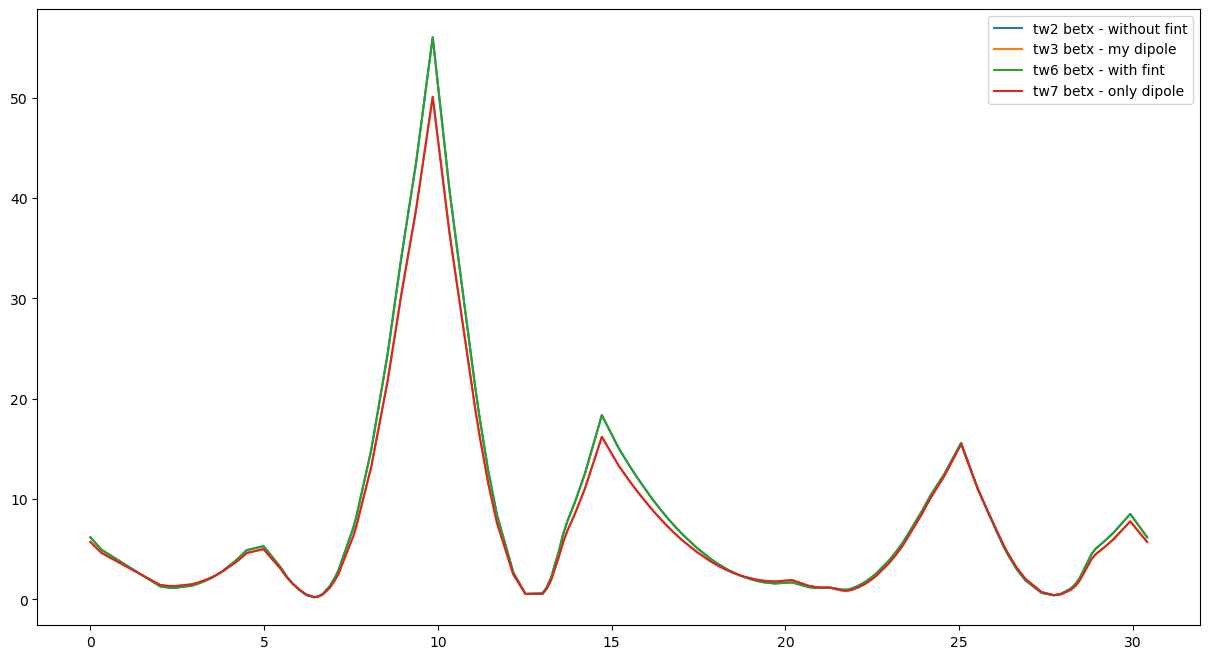

In [50]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(tw2.s, tw2.betx, label='tw2 betx - without fint')
ax.plot(tw3.s, tw3.betx, label='tw3 betx - my dipole')
ax.plot(tw6.s, tw6.betx, label='tw6 betx - with fint')
ax.plot(tw7.s, tw7.betx, label='tw7 betx - only dipole')
plt.legend()

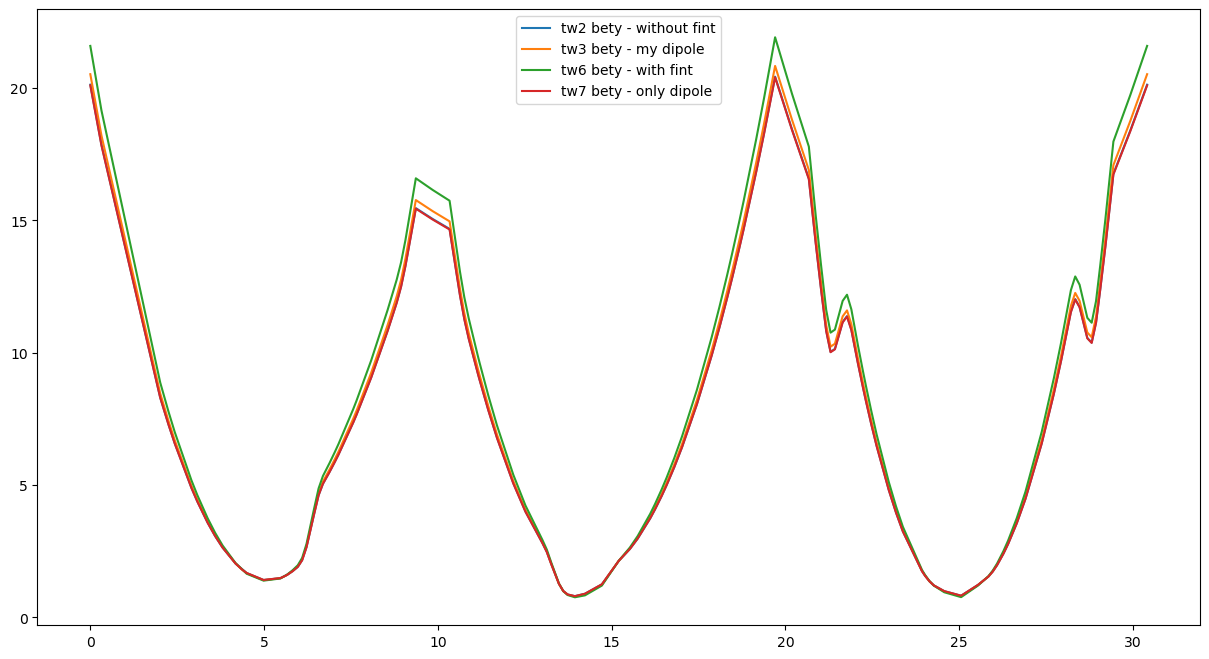

In [51]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(tw2.s, tw2.bety, label='tw2 bety - without fint')
ax.plot(tw3.s, tw3.bety, label='tw3 bety - my dipole')
ax.plot(tw6.s, tw6.bety, label='tw6 bety - with fint')
ax.plot(tw7.s, tw7.bety, label='tw7 bety - only dipole')
plt.legend()

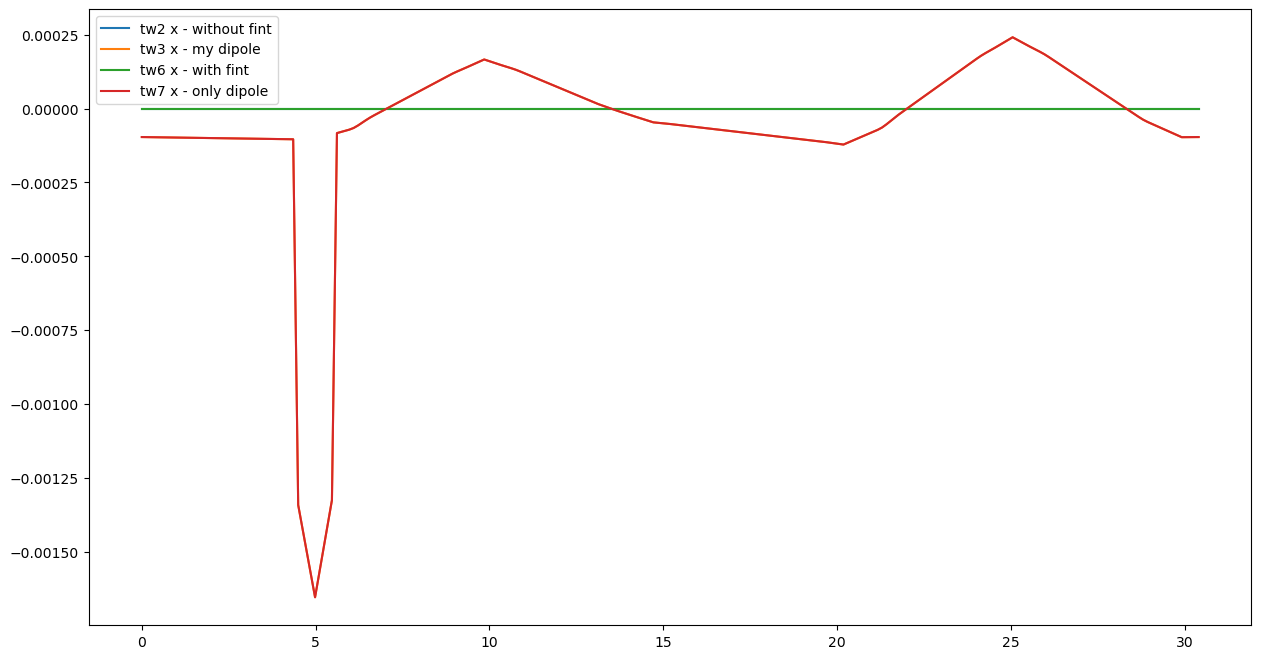

In [52]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(tw2.s, tw2.x, label='tw2 x - without fint')
ax.plot(tw3.s, tw3.x, label='tw3 x - my dipole')
ax.plot(tw6.s, tw6.x, label='tw6 x - with fint')
ax.plot(tw7.s, tw7.x, label='tw7 x - only dipole')
plt.legend()

In [53]:
print(tw2.qx)
print(tw3.qx)
print(tw2.qy)
print(tw3.qy)

2.360999999214117
2.3441945961549497
1.389999999999995
1.3871390821746938


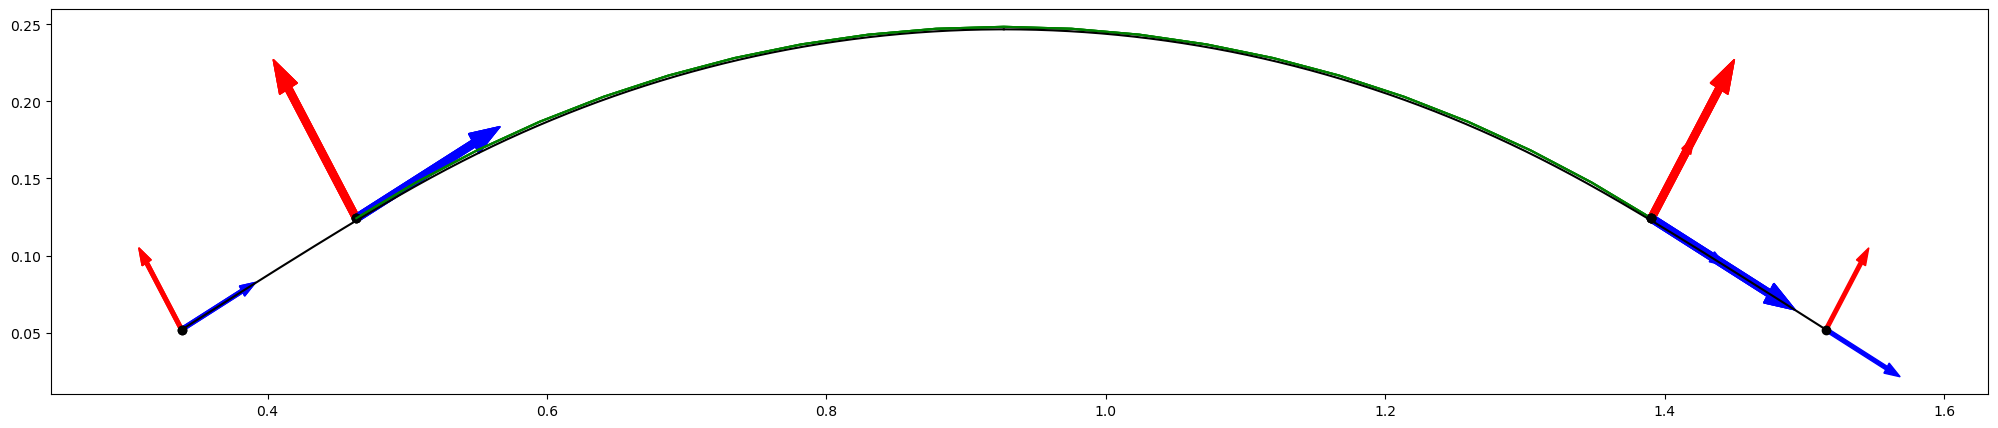

In [54]:
dipole_start = 4.3548

p0 = xt.Particles(x = tw3.x[tw3.s==dipole_start], px = tw3.px[tw3.s==dipole_start], y = tw3.y[tw3.s==dipole_start], py = tw3.py[tw3.s==dipole_start], p0c=0.1, mass0=0.938272, q0=1)
sol_sin = dipole_H_in_str.track(p0, return_sol=True)
sol_bin = dipole_H_in_curv.track(p0, return_sol=True)
sol_bout = dipole_H_out_curv.track(p0, return_sol=True)
sol_sout = dipole_H_out_str.track(p0, return_sol=True)

sedge = dipole_len/2
l_magn = dipole_len
smin = -sedge - extent
smax = sedge + extent
angle = dipole_len / rho

fig, ax = plt.subplots(figsize=(25, 5))
canvas = bpmeth.CanvasZX(fig, ax)
fr = bpmeth.Frame()
fr2 = fr.copy().arc_by(sedge, -angle/2)
fr3 = fr2.copy().move_by([(smin+sedge)*np.sin(angle/2), 0, (smin + sedge)*np.cos(angle/2)]).plot_zx(canvas=canvas)
fb = bpmeth.BendFrame(fr2, l_magn, angle).plot_zx(canvas=canvas)
fr4 = fb.end
fr5 = fr4.copy().move_by([-(smax-sedge)*np.sin(angle/2), 0, (smax - sedge)*np.cos(angle/2)]).plot_zx(canvas=canvas)
for i in range(len(p0.x)):
    fr3.plot_trajectory_zx(sol_sin[i].t-smin, sol_sin[i].y[0], sol_sin[i].y[1], canvas=canvas)
    fb.plot_trajectory_zx(sol_bin[i].t+sedge, sol_bin[i].y[0], sol_bin[i].y[1], canvas=canvas)
    fb.plot_trajectory_zx(sol_bout[i].t+sedge, sol_bout[i].y[0], sol_bout[i].y[1], canvas=canvas)
    fr4.plot_trajectory_zx(sol_sout[i].t-sedge, sol_sout[i].y[0], sol_sout[i].y[1], canvas=canvas)


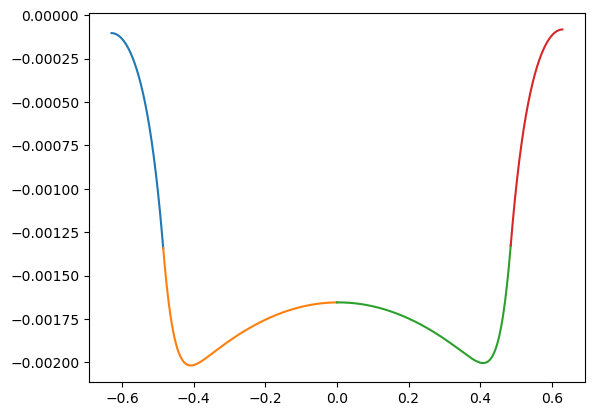

In [55]:
for i in range(len(p0.x)):
    plt.plot(sol_sin[i].t, sol_sin[i].y[0])
    plt.plot(sol_bin[i].t, sol_bin[i].y[0]) 
    plt.plot(sol_bout[i].t, sol_bout[i].y[0]) 
    plt.plot(sol_sout[i].t, sol_sout[i].y[0]) 


In [56]:
print(tw3.x[0], tw3.x[-1])

-9.622488546461773e-05 -9.622488511766896e-05


### Not rematched 

In [57]:
line4 = line.copy()

line4.remove("lnr.mbhek.0135.h1")
line4.remove("lnr.mbhek.0135.m")
line4.remove("lnr.mbhek.0135.h2")
# line4.insert("mydipole", dipole_H_full, at=dipole_s)
line4.insert("mydipole1", dipole_H_in_str, at=dipole_s - dipole_len/2 - extent/2)
line4.insert("mydipole2", dipole_H_in_curv, at=dipole_s - dipole_len/4)
line4.insert("mydipole3", dipole_H_out_curv, at=dipole_s + dipole_len/4)
line4.insert("mydipole4", dipole_H_out_str, at=dipole_s + dipole_len/2 + extent/2)
# line4["lnr.mbhek.0135.h1"].edge_entry_angle = 0
# line4["lnr.mbhek.0135.h2"].edge_exit_angle = 0


line4.insert("entrance_edge_quad", xt.Quadrupole(knl=(0, k1_edge)), at=dipole_s-dipole_len/2)
line4.insert("exit_edge_quad", xt.Quadrupole(knl=(0, k1_edge)), at=dipole_s+dipole_len/2)

# To compare: line without fringes, with quadrupoles to replace edges
line5 = line.copy()

line5["lnr.mbhek.0135.h1"].edge_entry_fint = 0
line5["lnr.mbhek.0135.h2"].edge_exit_fint = 0

line5["lnr.mbhek.0135.h1"].edge_entry_angle = 0
line5["lnr.mbhek.0135.h2"].edge_exit_angle = 0

line5.insert("entrance_edge_quad", xt.Quadrupole(knl=(0, k1_edge)), at=dipole_s-dipole_len/2)
line5.insert("exit_edge_quad", xt.Quadrupole(knl=(0, k1_edge)), at=dipole_s+dipole_len/2)

tab4 = line4.get_table()
tab4.show(cols=['s_start', 's_center', 's_end'])

Slicing line:   0%|          | 0/198 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/199 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/199 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/199 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/200 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/201 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/199 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/200 [00:00<?, ?it/s]

name                          s_start      s_center         s_end
elena$start                         0             0             0
lnr.startsurvey                     0             0             0
lnr.begin                           0             0             0
section1$start                      0             0             0
drift_0                             0        0.1603        0.3206
lnr.mccay.0105                 0.3206        0.3206        0.3206
lnr.bpmeb.0110                 0.3206        0.3206        0.3206
drift_1                        0.3206       1.16575        2.0109
lnr.vvgbf.0114                 2.0109        2.0109        2.0109
drift_2                        2.0109       2.13025        2.2496
lnr.mmidinj                    2.2496        2.2496        2.2496
drift_3                        2.2496        2.3396        2.4296
lnr.mbmie.0115                 2.4296        2.4296        2.4296
drift_4                        2.4296       2.66905        2.9085
lnr.btvpa.

In [58]:
tw4=line4.twiss4d(betx=1, bety=1, x=0, y=0, include_collective=True)
# tw4=line4.twiss4d()
tw5=line5.twiss4d(betx=1, bety=1)

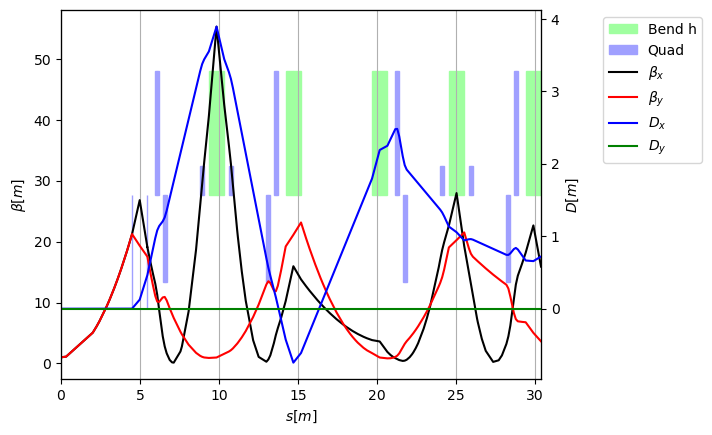

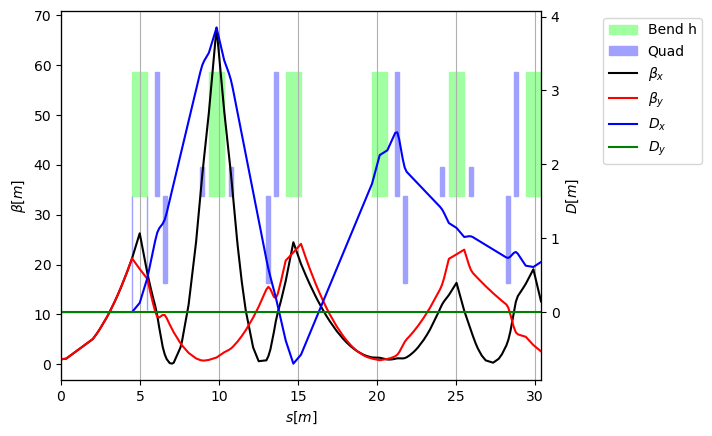

In [59]:
tw4.plot()
tw5.plot()

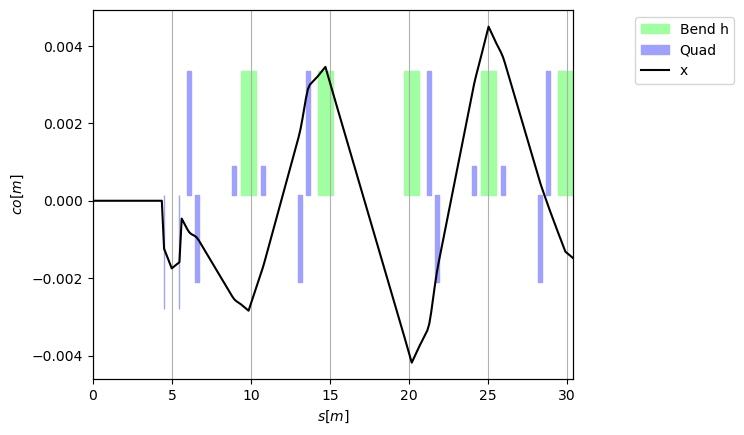

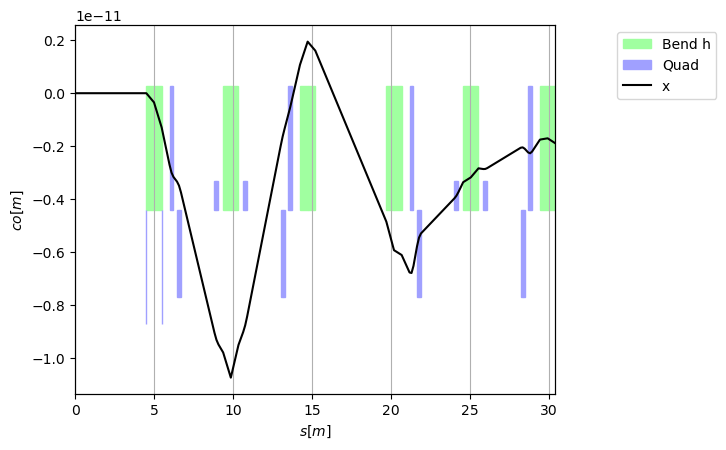

In [60]:
tw4.plot("x")
tw5.plot("x")

In [61]:
print(line6["lnr.mbhek.0135.h1"])
print(line2["lnr.mbhek.0135.h1"])
print(line6["lnr.mbhek.0135.h2"])
print(line2["lnr.mbhek.0135.h2"])

View of Bend(length=0.485, k0=1.08, k1=0, h=1.08, k0_from_h=True, model='adaptive', knl=array([0., 0., 0., 0., 0., 0.]), ksl=array([0., 0., 0., 0., 0., 0.]), edge_entry_active=np.int64(1), edge_exit_active=np.int64(1), edge_entry_model='full', edge_exit_model='full', edge_entry_angle=0, edge_exit_angle=0, edge_entry_angle_fdown=0, edge_exit_angle_fdown=0, edge_entry_fint=0.424, edge_exit_fint=0, edge_entry_hgap=0.038, edge_exit_hgap=0.038, shift_x=0, shift_y=0, rot_s_rad=0)
View of Bend(length=0.485, k0=1.08, k1=0, h=1.08, k0_from_h=True, model='adaptive', knl=array([0., 0., 0., 0., 0., 0.]), ksl=array([0., 0., 0., 0., 0., 0.]), edge_entry_active=np.int64(1), edge_exit_active=np.int64(1), edge_entry_model='full', edge_exit_model='full', edge_entry_angle=0, edge_exit_angle=0, edge_entry_angle_fdown=0, edge_exit_angle_fdown=0, edge_entry_fint=0, edge_exit_fint=0, edge_entry_hgap=0.038, edge_exit_hgap=0.038, shift_x=0, shift_y=0, rot_s_rad=0)
View of Bend(length=0.485, k0=1.08, k1=0, h=1.

Dipoles:  
"lnr.mbhek.0135", "lnr.mbhek.0245", "lnr.mbhek.0335", "lnr.mbhek.0470", "lnr.mbhek.0560", "lnr.mbhek.0640"

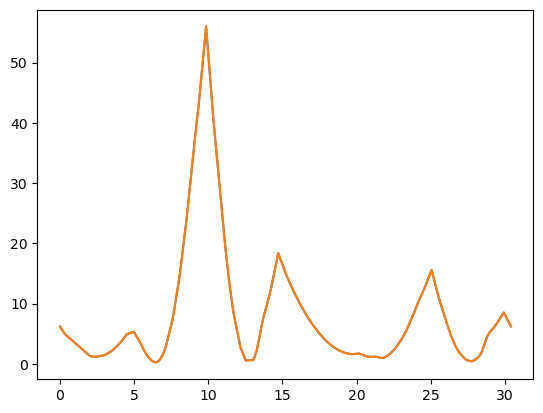

In [62]:
tw2=line2.twiss4d()
tw6=line6.twiss4d()
plt.plot(tw2.s, tw2.betx, label='tw2 betx - without fint')
plt.plot(tw6.s, tw6.betx, label='tw6 betx - with fint')